# GMM

It is a probabilistic approach to clustering addressing many of these problems. In this approach we describe each cluster by its centroid (mean), covariance , and the size of the cluster(Weight)

### Aproach

* Rather than identifying clusters by “nearest” centroids like k means, we fit a set of k gaussians to the data. 
* Then we estimate gaussian distribution parameters such as mean and Variance for each cluster and weight of a cluster. 
* After learning the parameters for each data point we can calculate the probabilities of it belonging to each of the clusters.

### How do we estimate GD params

* Expectation maximization is the technique most commonly used to estimate the mixture model's parameters. 
* In frequentist probability theory, models are typically learned by using maximum likelihood estimation techniques, which seek to maximize the probability, or likelihood, of the observed data given the model parameters. 

Well it's hard to visualize and grab these concepts in first shot. Here is some material for deep dive in gmm
* http://www.cse.iitm.ac.in/~vplab/courses/DVP/PDF/gmm.pdf

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

%matplotlib inline

In [50]:
data = pd.read_csv('my_machine-learning/datasets/iris.csv')
data = data.drop('Id', axis=1) # get rid of the Id column - don't need it
data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
75,6.6,3.0,4.4,1.4,Iris-versicolor
36,5.5,3.5,1.3,0.2,Iris-setosa
129,7.2,3.0,5.8,1.6,Iris-virginica
73,6.1,2.8,4.7,1.2,Iris-versicolor
83,6.0,2.7,5.1,1.6,Iris-versicolor


In [51]:
X = data.iloc[:,0:4]
y = data.iloc[:,-1]

### Standard Scaling

In [52]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

In [53]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=3)
y_kmeans = kmean.fit_predict(X_scaled)

#### Adjusted Rand score

* you can't just compare the SpeciesId with the cluster numbers, because they are both arbitrarily assigned integers.
* But you can use the *adjusted Rand score* to quantify the goodness of the clustering, as compared with SpeciesId (the true labels).

* e.g. this will give a perfect score of 1.0, even though the labels are reversed - adjusted_rand_score([0,0,1,1], [1,1,0,0]) # => 1.0

see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html


In [54]:
from sklearn.metrics.cluster import adjusted_rand_score

# first let's see how the k-means clustering did - 
score = adjusted_rand_score(y, y_kmeans)
score

0.6201351808870379

In [55]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
y_gmm = gmm.fit_predict(X_scaled)


* GMM tries to fit normally distributed clusters, which is probably the case with this data,
* so it fit it better. k-means is biased towards spherically distributed clusters.

In [56]:
score = adjusted_rand_score(y, y_gmm)
score

0.9038742317748124

* **Its impossible to create 4d graph without some dimensionality reduction technique like pca** 
* So we will create one after learning pca

### Part 2

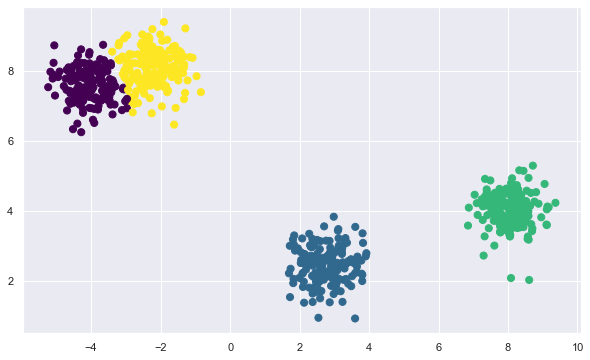

In [70]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import numpy as np

from sklearn.datasets import make_blobs, make_circles
X, y_true = make_blobs(n_samples=700, centers=4,cluster_std=0.5, random_state=2019)
X = X[:, ::-1]

from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)

labels = gmm.predict(X)
plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()


In [17]:
plt.savefig('gmm.jpg')

<Figure size 432x288 with 0 Axes>

In [18]:
probs = gmm.predict_proba(X)
print(probs[:10].round(2))

[[0.   0.55 0.   0.45]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.57 0.   0.43]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   1.   0.  ]]


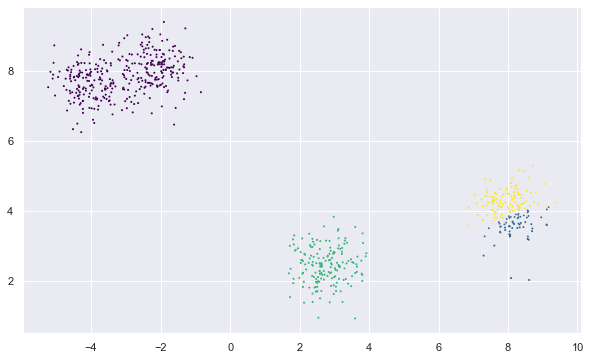

In [23]:
size = probs.max(1)
plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)
plt.show()

In [21]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=4, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=4, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_  , gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

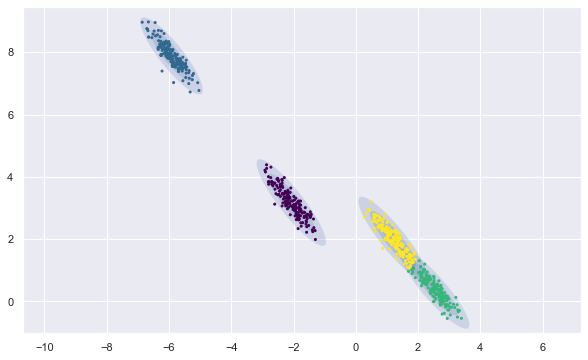

In [24]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plt.figure(figsize=(10,6))
plot_gmm(gmm, X_stretched)

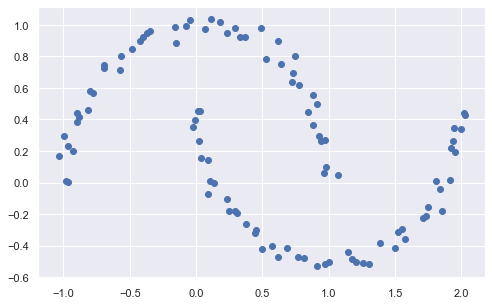

In [54]:
from sklearn.datasets import make_moons
moon,y = make_moons(100, noise=.04, random_state=0)
plt.figure(figsize=(8,5))
plt.scatter(x=moon[:, 0], y=moon[:, 1])
plt.show()

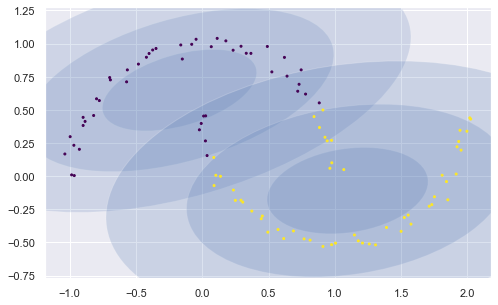

In [53]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plt.figure(figsize=(8,5))
plot_gmm(gmm2, moon)

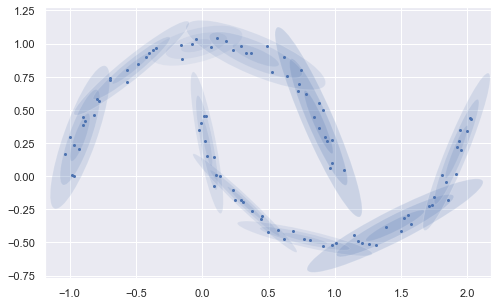

In [56]:
gmm10 = GMM(n_components=10, covariance_type='full', random_state=0)
plt.figure(figsize=(8,5))
plot_gmm(gmm10, moon, label=False)


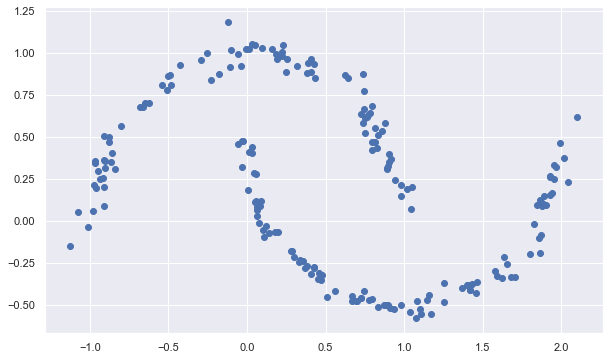

In [65]:
Xnew = gmm10.sample(200)[0]
plt.figure(figsize=(10,6))
plt.scatter(Xnew[:, 0], Xnew[:, 1])
plt.show()

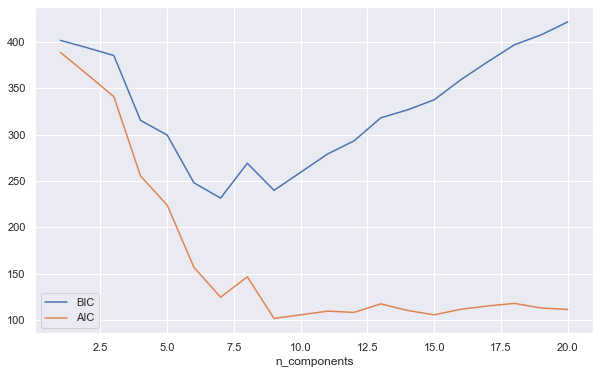

In [62]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(moon) for n in n_components]

plt.figure(figsize=(10,6))
plt.plot(n_components, [m.bic(moon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(moon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

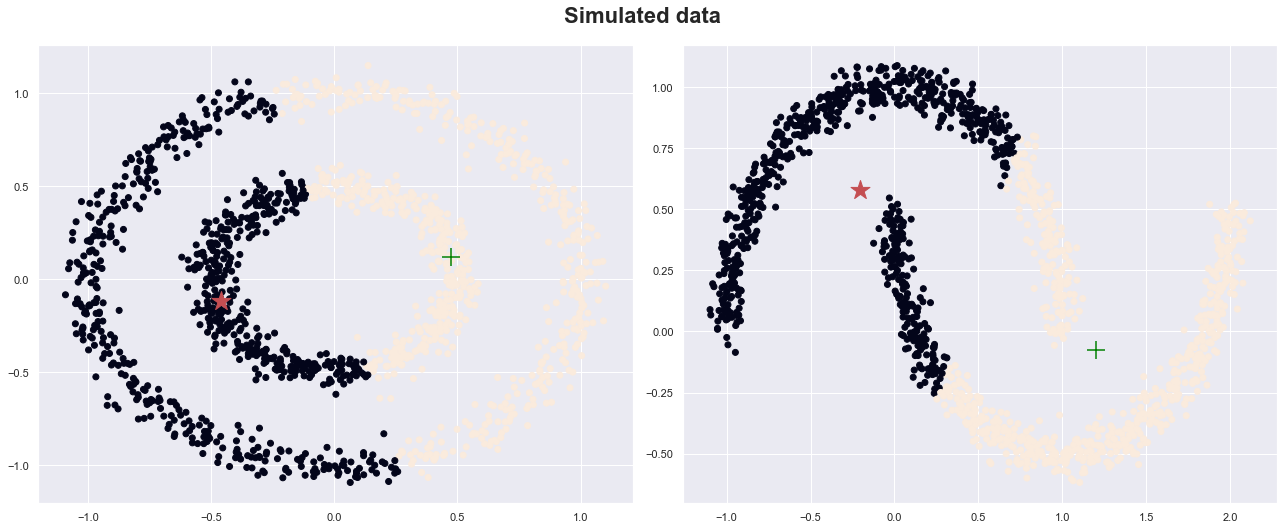

In [72]:
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    km = KMeans(n_clusters=2)
    km.fit(X[0])
    labels = km.predict(X[0])
    centroids = km.cluster_centers_

    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
    ax[i].scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='r')
    ax[i].scatter(centroids[1, 0], centroids[1, 1], marker='+', s=300, c='green')
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()